# Camera Calibration

In [1]:
# # UNIX-based system
# base_path = "d:\\VIBOT Master\\Semester 2\\Computer Vision\\Practicals\\Stereo\\stereo_reconstruction_cv"

# KINUX-based system
base_path = "/home/rafay/Documents/rafay/MyFolder_other_stuff/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv"

In [2]:
# !pip3 install numpy
# !pip3 install opencv-python
# !pip3 install open3d
# !pip3 install matplotlib

import numpy as np
import cv2
import glob
import os
import open3d as o3d
import matplotlib.pyplot as plt
import sys

# 1. Camera Calibration
checkerboardsize = (9, 7)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((checkerboardsize[0] * checkerboardsize[1], 3), np.float32)
objp[:, :2] = np.mgrid[0 : checkerboardsize[0], 0 : checkerboardsize[1]].T.reshape(
    -1, 2
)

objpoints = []
imgpoints = []
images = glob.glob("calibration_data_logitech_3840x2160/*.jpg")
images = sorted([os.path.join(base_path, img_path) for img_path in images])
annotation_dir = "chessboard_corners"
save_chessboard_corner_ann = True
if not os.path.exists(annotation_dir) and save_chessboard_corner_ann:
    os.mkdir(annotation_dir)

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(
        gray,
        checkerboardsize,
        cv2.CALIB_CB_ADAPTIVE_THRESH
        + cv2.CALIB_CB_FAST_CHECK
        + cv2.CALIB_CB_NORMALIZE_IMAGE,
    )

    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        if save_chessboard_corner_ann:
            fname_ = (
                os.path.join(base_path, annotation_dir)
                + "/"
                + fname.split("/")[-1].split(".")[0]
                + "corner_plot.jpg"
            )
            cv2.drawChessboardCorners(img, checkerboardsize, corners2, ret)
            cv2.imwrite(fname_, img)

ret, cameraMatrix, dist, rvec, tvec = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None
)

# Compute reprojection error
reprojection_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(
        objpoints[i], rvec[i], tvec[i], cameraMatrix, dist
    )
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    reprojection_error += error
reprojection_error /= len(objpoints)
print("Reprojection error:", reprojection_error)
print("Camera Calibrated:   ", ret)
print("Camera Matrix:   ", cameraMatrix)
print("Distortion Parameters:   ", dist)
print("Rotation Vector: ", rvec)
print("Translation Vector: ", tvec)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Reprojection error: 0.14875925765044806
Camera Calibrated:    1.3396757464751792
Camera Matrix:    [[2.25370759e+03 0.00000000e+00 1.92969309e+03]
 [0.00000000e+00 2.24471892e+03 1.05763445e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Parameters:    [[ 2.08993190e-01 -5.57647266e-01 -7.19877887e-06  5.16897145e-04
   3.81154053e-01]]
Rotation Vector:  (array([[ 0.0423316 ],
       [-0.01053158],
       [ 0.0203875 ]]), array([[-0.0618124 ],
       [-0.07042272],
       [ 1.55299835]]), array([[ 0.0633967 ],
       [-0.09186907],
       [ 0.79679293]]), array([[ 0.04796078],
       [-0.21691397],
       [-0.02970658]]), array([[ 0.23029487],
       [-0.21473849],
       [-0.28463919]]), array([[-0.08643709],
       [ 0.2049388 ],
       [ 0.19885457]]), array([[-0.28777851],
       [-0.05864591],
    

# Rectification

In [3]:
def stereo_rectify(K0, K1, R, T, image_size):
    """Performs stereo rectification.

    This function takes the camera intrinsic parameters (K0, K1), rotation (R), 
    translation (T) between the two cameras, and the image size, and returns 
    the rectification transformations (R1, R2, P1, P2) and the disparity-to-depth 
    mapping matrix (Q).  It uses OpenCV's stereoRectify function.

    Args:
        K0: Camera intrinsic matrix for the left camera (3x3 numpy array).
        K1: Camera intrinsic matrix for the right camera (3x3 numpy array).
        R: Rotation matrix between the two cameras (3x3 numpy array).
        T: Translation vector between the two cameras (3x1 or 1x3 numpy array).
        image_size: Size of the image (tuple or list of (width, height)).

    Returns:
        R1: Rectification rotation matrix for the left camera (3x3 numpy array).
        R2: Rectification rotation matrix for the right camera (3x3 numpy array).
        P1: Projection matrix for the left camera after rectification (3x4 numpy array).
        P2: Projection matrix for the right camera after rectification (3x4 numpy array).
        Q: Disparity-to-depth mapping matrix (4x4 numpy array).
    """
    T = T.astype(np.float64)  # Ensure T is float64 for cv2.stereoRectify

    R1, R2, P1, P2, Q = cv2.stereoRectify(K0, None, K1, None, image_size, R, T)
    return R1, R2, P1, P2, Q

In [4]:
def draw_epilines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [5]:
# Example usage (replace with your actual paths)
left_image = "dataset/d3/img1.jpg"
right_image = "dataset/d3/img2.jpg"

# Read Images
imgL = cv2.imread(left_image, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(right_image, cv2.IMREAD_GRAYSCALE)
imgL_color = cv2.imread(left_image)  # For color visualization

baseline = 140
K0 = np.array(cameraMatrix)
K1 = np.array(cameraMatrix)
R = np.eye(3)  # Identity matrix (no rotation)
T = np.array([[baseline], [0], [0]])
image_size = (int(3840), int(2160))

In [6]:
## Tutorial : https://docs.opencv.org/4.x/da/de9/tutorial_py_epipolar_geometry.html

# Use SIFT for feature detection and matching
sift = cv2.SIFT_create()
keypoints_left, descriptors_left = sift.detectAndCompute(imgL, None)
keypoints_right, descriptors_right = sift.detectAndCompute(imgR, None)
 
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

# Use FLANN-based matcher to find correspondences
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)
 
# Filter matches using the Lowe's ratio test
pts_left = []
pts_right = []
 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        pts_left.append(keypoints_left[m.queryIdx].pt)
        pts_right.append(keypoints_right[m.trainIdx].pt)


pts_left = np.int32(pts_left)
pts_right = np.int32(pts_right)
F, mask = cv2.findFundamentalMat(pts_left,pts_right,cv2.FM_LMEDS)

# We select only inlier points
pts_left = pts_left[mask.ravel()==1]
pts_right = pts_right[mask.ravel()==1]

# Compute the Essential Matrix
E, mask = cv2.findEssentialMat(pts_left, pts_right, K0, method=cv2.RANSAC, prob=0.999, threshold=1.0)
 
# Decompose the Essential Matrix to recover R and T
_, R, T, _ = cv2.recoverPose(E, pts_left, pts_right, K0)

print("Fundemental Matrix (F):\n", F) 
print("Relative Rotation (R):\n", R)
print("Relative Translation (T):\n", T)


Fundemental Matrix (F):
 [[-8.17362050e-09  9.38323472e-07 -1.05966632e-03]
 [-9.27365779e-07 -2.18702572e-07  1.25353975e-02]
 [ 1.09441902e-03 -1.24324415e-02  1.00000000e+00]]
Relative Rotation (R):
 [[ 0.99965105  0.00774432  0.02525461]
 [-0.00668948  0.99911244 -0.04158829]
 [-0.02555427  0.04140483  0.99881561]]
Relative Translation (T):
 [[ 0.99902419]
 [ 0.04297367]
 [-0.01019455]]


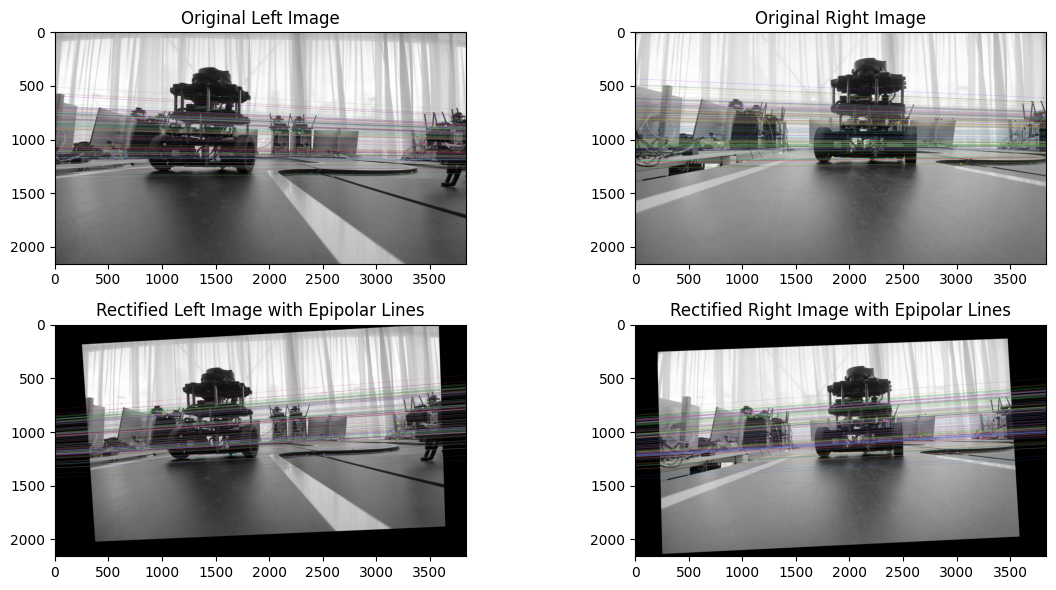

True

In [7]:
## git gist : https://gist.github.com/jensenb/8668000

## Epilines before rectification

# Find epilines corresponding to points in right image and
# drawing its lines on left image
left_before_lines = cv2.computeCorrespondEpilines(pts_right.reshape(-1,1,2), 2,F)
left_before_lines = left_before_lines.reshape(-1,3)
imgL_before_rec,_ = draw_epilines(imgL,imgR,left_before_lines,pts_left,pts_right)

# Find epilines corresponding to points in left image and
# drawing its lines on right image
right_before_lines = cv2.computeCorrespondEpilines(pts_left.reshape(-1,1,2), 1,F)
right_before_lines = right_before_lines.reshape(-1,3)
imgR_before_rec,_ = draw_epilines(imgR,imgL,right_before_lines,pts_right,pts_left)

# Stereo rectification using assumed R and T (no rotation, baseline translation)
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
    K0, None, K1, None, image_size, R, T, alpha=1.0
)

# Rectify Images
mapL1, mapL2 = cv2.initUndistortRectifyMap(K0, None, R1, P1, image_size, cv2.CV_32F)
mapR1, mapR2 = cv2.initUndistortRectifyMap(K1, None, R2, P2, image_size, cv2.CV_32F)

imgL_rect = cv2.remap(imgL, mapL1, mapL2, interpolation=cv2.INTER_LINEAR)
imgR_rect = cv2.remap(imgR, mapR1, mapR2, interpolation=cv2.INTER_LINEAR)
# imgL_rect_color = cv2.remap(imgL_color, mapL1, mapL2, interpolation=cv2.INTER_LINEAR)

## REDO everything now for the rectified pair 
# Use SIFT for feature detection and matching
sift = cv2.SIFT_create()
keypoints_left_rect, descriptors_left_rect = sift.detectAndCompute(imgL_rect, None)
keypoints_right_rect, descriptors_right_rect = sift.detectAndCompute(imgR_rect, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

# Use FLANN-based matcher to find correspondences
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descriptors_left_rect, descriptors_right_rect, k=2)

# Filter matches using the Lowe's ratio test
pts_left_rect = []
pts_right_rect = []
 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        pts_left_rect.append(keypoints_left_rect[m.queryIdx].pt)
        pts_right_rect.append(keypoints_right_rect[m.trainIdx].pt)


pts_left_rect = np.int32(pts_left_rect)
pts_right_rect = np.int32(pts_right_rect)
F_rect, mask = cv2.findFundamentalMat(pts_left_rect,pts_right_rect,cv2.FM_LMEDS)

# We select only inlier points
pts_left_rect = pts_left_rect[mask.ravel()==1]
pts_right_rect = pts_right_rect[mask.ravel()==1]

# Draw epipolar lines on the rectified images

# Find epilines corresponding to points in right image and
# drawing its lines on left image
left_after_lines = cv2.computeCorrespondEpilines(pts_right_rect.reshape(-1,1,2), 2,F_rect)
left_after_lines = left_after_lines.reshape(-1,3)
imgL_after_rec,_ = draw_epilines(imgL_rect,imgR_rect,left_after_lines,pts_left_rect,pts_right_rect)

# Find epilines corresponding to points in left image and
# drawing its lines on right image
right_after_lines = cv2.computeCorrespondEpilines(pts_right_rect.reshape(-1,1,2), 1,F_rect)
right_after_lines = right_after_lines.reshape(-1,3)
imgR_after_rec,_ = draw_epilines(imgR_rect,imgL_rect,right_after_lines,pts_right_rect,pts_left_rect)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title("Original Left Image")
plt.imshow(imgL_before_rec, cmap="gray")

plt.subplot(2, 2, 2)
plt.title("Original Right Image")
plt.imshow(imgR_before_rec, cmap="gray")

plt.subplot(2, 2, 3)
plt.title("Rectified Left Image with Epipolar Lines")
plt.imshow(imgL_after_rec, cmap="gray")

plt.subplot(2, 2, 4)
plt.title("Rectified Right Image with Epipolar Lines")
plt.imshow(imgR_after_rec, cmap="gray")

plt.tight_layout()
plt.show()

# Save the rectified images
cv2.imwrite("left_rectified.jpg", imgL_rect)
cv2.imwrite("right_rectified.jpg", imgR_rect)
cv2.imwrite("right_rectified_lines.jpg", imgR_after_rec)
cv2.imwrite("left_rectified_lines.jpg", imgL_after_rec)


In [8]:
R1, R2, P1, P2, Q

(array([[ 0.99864863,  0.05025019,  0.0132603 ],
        [-0.04995994,  0.99852235, -0.02138055],
        [-0.01431508,  0.02068917,  0.99968347]]),
 array([[ 0.99902419,  0.04297367, -0.01019455],
        [-0.04274959,  0.99885948,  0.02126512],
        [ 0.01109676, -0.02080855,  0.99972189]]),
 array([[1.93567948e+03, 0.00000000e+00, 1.92262006e+03, 0.00000000e+00],
        [0.00000000e+00, 1.93567948e+03, 1.05745935e+03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 array([[1.93567948e+03, 0.00000000e+00, 1.92262006e+03, 1.93567948e+03],
        [0.00000000e+00, 1.93567948e+03, 1.05745935e+03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.92262006e+03],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         -1.05745935e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.93567948

# Disparity

In [21]:
def compute_disparity_map(imgL, imgR, ndisp, mindis):
    """
    Compute disparity map from stereo images.

    Parameters:
    - imgL (numpy.ndarray): Left image as a grayscale numpy array.
    - imgR (numpy.ndarray): Right image as a grayscale numpy array.
    - ndisp (int): Upper bound on disparity levels.
    - mindis (int): Minimum disparity value.
    Returns:
    - disparity_map (numpy.ndarray): Disparity map as a float32 numpy array.

    This function uses the StereoSGBM algorithm to compute the disparity map from the left and right images.
    The disparity map is a 2D array where each pixel value represents the disparity between the corresponding points in the left and right images.
    The disparity map is computed using the StereoSGBM algorithm, which is a block-matching algorithm that estimates the disparity by finding the
    best match for each block of pixels in the left image in the right image. The algorithm uses a cost function to measure the similarity between
    the blocks and selects the block with the lowest cost as the best match. The disparity map is then computed by dividing the difference in pixel
    positions between the left and right images by the baseline.

    The function takes as input the left and right images as grayscale numpy arrays, as well as the upper bound on disparity levels (ndisp) and
    the minimum disparity value (mindis). The function returns the disparity map as a float32 numpy array.
    """
    # Using StereoSGBM for better results (more parameters to tune)
    stereo = cv2.StereoSGBM_create(
        minDisparity=mindis,
        numDisparities=ndisp,
        blockSize=11,  # You can experiment with this value (odd numbers: 3, 5, 7, ...)
        P1=8 * 3 * 11**2,  # Adjusted parameters (proportional to blockSize)
        P2=32 * 3 * 11**2,  # Adjusted parameters (proportional to blockSize)
        disp12MaxDiff=1,
        preFilterCap=63,  # add this parameter
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32,
    )

    disparity_map = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    mask = disparity_map > 0  # Example: keep only positive disparities
    disparity_map = disparity_map * mask.astype(np.float32)
    return disparity_map

In [22]:
def reconstruct_3D(disparity_map: np.ndarray, Q: np.ndarray) -> np.ndarray:
    """Reconstructs 3D points from a disparity map using a Q matrix.

    This function takes a disparity map and a Q (disparity-to-depth) matrix 
    and uses OpenCV's `cv2.reprojectImageTo3D` to reconstruct a 3D point cloud.

    Args:
        disparity_map: The disparity map (NumPy array, usually float32).
        Q: The disparity-to-depth mapping matrix (4x4 NumPy array).

    Returns:
        A 3D point cloud (NumPy array).  The shape of the returned array 
        is (height, width, 3), where each element [y, x, :] represents the 
        3D coordinates (x, y, z) of the point corresponding to pixel (x, y) 
        in the disparity map.  Returns None if there is an error.
    """
    try:
        points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
        return points_3D
    except Exception as e:
        print(f"Error in reconstruct_3D: {e}")
        return None

In [35]:
def visualize_point_cloud(points_3D):
    """
    Visualize the 3D point cloud using Open3D.

    Parameters:
    - points_3D: 3D points to visualize.
    """
    # Create a point cloud object
    pcd = o3d.geometry.PointCloud()

    # Set the points
    pcd.points = o3d.utility.Vector3dVector(
        points_3D.T
    )  # Transpose to match Open3D format

    # Optionally, set colors (here we set all points to red)
    colors = np.array([[1, 0, 0] for _ in range(points_3D.shape[1])])  # Red color
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # Visualize the point cloud
    o3d.visualization.draw_geometries(
        [pcd], window_name="3D Point Cloud", width=800, height=600
    )

# Feature Detection and Matching with SIFT

In [26]:
def feat_detect_match(stereo_path, contrast_threshold=0.04):
    sift = cv2.SIFT_create(contrastThreshold=contrast_threshold)

    left_image = glob.glob(f"{stereo_path}/img1.jpg")
    right_image = glob.glob(f"{stereo_path}/img2.jpg")

    if not left_image or not right_image:
        return "Error: Missing img1.jpg or img2.jpg in the folder."

    imgL = cv2.imread(left_image[0], cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(right_image[0], cv2.IMREAD_GRAYSCALE)

    if imgL is None or imgR is None:
        return "Error: Failed to load one or both images."

    keypoints_left, descriptors_left = sift.detectAndCompute(imgL, None)
    keypoints_right, descriptors_right = sift.detectAndCompute(imgR, None)
    print(f"SIFT: {len(keypoints_left)} keypoints detected in left image.")
    print(f"SIFT: {len(keypoints_right)} keypoints detected in right image.")

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # Use FLANN-based matcher to find correspondences
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)

    # Filter matches using the Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    print(
        f"FLANN Matcher: {len(matches)} matches found, {len(good_matches)} after ratio test."
    )

    imgL_with_kp = cv2.drawKeypoints(
        imgL, keypoints_left, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    imgR_with_kp = cv2.drawKeypoints(
        imgR, keypoints_right, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    img_matches = cv2.drawMatchesKnn(
        imgL,
        keypoints_left,
        imgR,
        keypoints_right,
        matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    img_good_matches = cv2.drawMatches(
        imgL,
        keypoints_left,
        imgR,
        keypoints_right,
        good_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )

    # Resize images for display
    print(imgL_with_kp.shape[:3])
    imgL_with_kp = cv2.resize(imgL_with_kp, (640, 360))
    imgR_with_kp = cv2.resize(imgR_with_kp, (640, 360))
    img_matches = cv2.resize(img_matches, (1280, 360))  # Wider image for matches
    img_good_matches = cv2.resize(
        img_good_matches, (1280, 360)
    )  # Wider image for matches

    # extract points
    pts1 = []
    pts2 = []
    for i, (m) in enumerate(good_matches):
        pts2.append(keypoints_right[m.trainIdx].pt)
        pts1.append(keypoints_left[m.queryIdx].pt)
    pts1 = np.asarray(pts1)
    pts2 = np.asarray(pts2)

    # # Compute fundamental matrix
    # F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
    # _, R, t, _ = cv2.recoverPose(E, pts1, pts2, cameraMatrix)

    # print("Fundamental Matrix with RANSAC: \n", F)

    return imgL_with_kp, imgR_with_kp, img_matches, img_good_matches, pts1, pts2

SIFT: 6774 keypoints detected in left image.
SIFT: 6107 keypoints detected in right image.
FLANN Matcher: 6774 matches found, 513 after ratio test.
(2160, 3840, 3)


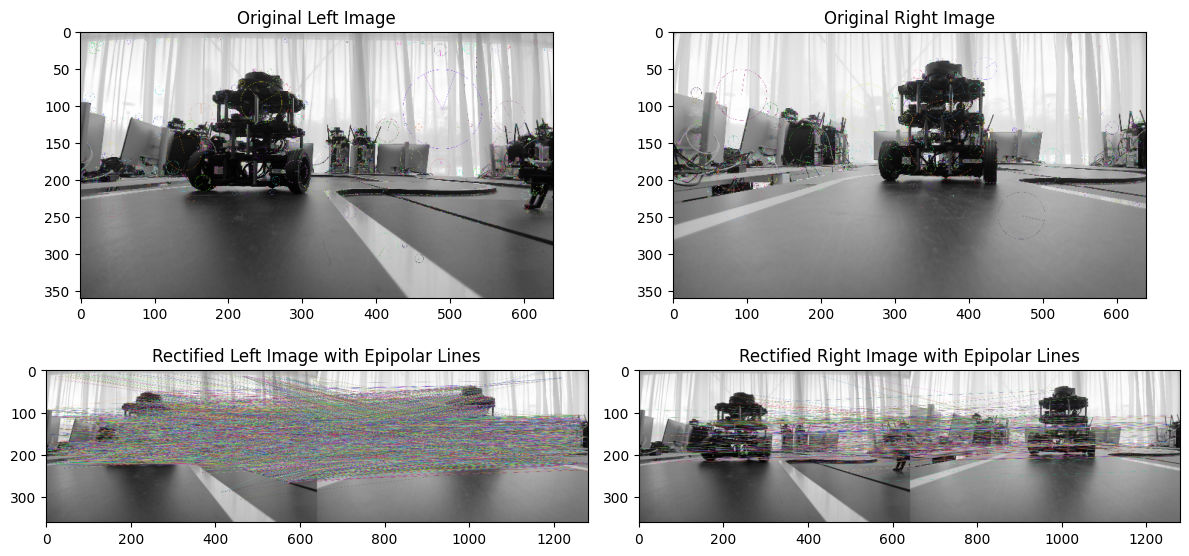

True

In [27]:
(imgL_with_kp, imgR_with_kp, img_matches, img_good_matches, pts1, pts2) = (
    feat_detect_match("dataset/d3")
)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title("Original Left Image")
plt.imshow(imgL_with_kp)

plt.subplot(2, 2, 2)
plt.title("Original Right Image")
plt.imshow(imgR_with_kp)

plt.subplot(2, 2, 3)
plt.title("Rectified Left Image with Epipolar Lines")
plt.imshow(img_matches)

plt.subplot(2, 2, 4)
plt.title("Rectified Right Image with Epipolar Lines")
plt.imshow(img_good_matches)

plt.tight_layout()
plt.show()

# Save the rectified images
cv2.imwrite("imgL_with_kp.jpg", imgL_with_kp)
cv2.imwrite("imgR_with_kp.jpg", imgR_with_kp)
cv2.imwrite("img_matches.jpg", img_matches)
cv2.imwrite("img_good_matches.jpg", img_good_matches)

In [28]:
def stereo_geometry_estimation(
    stereo_path, baseline=0.1, cameraMatrix1=None, cameraMatrix2=None
):
    if cameraMatrix1 is None:
        cameraMatrix1 = np.array([[1000, 0, 1920 / 2], [0, 1000, 1080 / 2], [0, 0, 1]])
        print("cameraMatrix1 was not given. Using default cameraMatrix", cameraMatrix1)
    if cameraMatrix2 is None:
        cameraMatrix2 = np.array([[1000, 0, 1920 / 2], [0, 1000, 1080 / 2], [0, 0, 1]])
        print("cameraMatrix2 was not given. Using default cameraMatrix", cameraMatrix2)
        # Default if not provided

    left_image = glob.glob(f"{stereo_path}/img1.jpg")
    right_image = glob.glob(f"{stereo_path}/img2.jpg")

    if not left_image or not right_image:
        return "Error: Missing img1.jpg or img2.jpg in the folder."

    imgL = cv2.imread(left_image[0], cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(right_image[0], cv2.IMREAD_GRAYSCALE)
    image_dims = imgL.shape

    K0 = np.array(cameraMatrix1)
    K1 = np.array(cameraMatrix2)
    R = np.eye(3)  # Identity matrix (no rotation)
    T = np.array([[baseline], [0], [0]])

    # Use SIFT for feature detection and matching
    sift = cv2.SIFT_create()
    keypoints_left, descriptors_left = sift.detectAndCompute(imgL, None)
    keypoints_right, descriptors_right = sift.detectAndCompute(imgR, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # Use FLANN-based matcher to find correspondences
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)

    # Filter matches using the Lowe's ratio test
    pts_left = []
    pts_right = []
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            pts_left.append(keypoints_left[m.queryIdx].pt)
            pts_right.append(keypoints_right[m.trainIdx].pt)

    pts_left = np.int32(pts_left)
    pts_right = np.int32(pts_right)
    F, mask = cv2.findFundamentalMat(pts_left, pts_right, cv2.FM_LMEDS)

    # Select only inlier points
    pts_left = pts_left[mask.ravel() == 1]
    pts_right = pts_right[mask.ravel() == 1]

    # Compute the Essential Matrix
    E, mask = cv2.findEssentialMat(
        pts_left, pts_right, K0, method=cv2.RANSAC, prob=0.999, threshold=1.0
    )

    # Decompose the Essential Matrix to recover R and T
    _, R, T, _ = cv2.recoverPose(E, pts_left, pts_right, K0)

    return {"essential_matrix": E, "rotation_matrix": R, "translation_vector": T}

In [29]:
stereo_geometry = stereo_geometry_estimation(
    "dataset/d3",
    baseline=140,
    cameraMatrix1=cameraMatrix,
    cameraMatrix2=cameraMatrix,
)
print(stereo_geometry)

{'essential_matrix': array([[ 4.43856829e-04, -5.27118176e-02, -1.36080073e-02],
       [ 5.40610371e-02, -2.63921809e-02, -7.04370217e-01],
       [ 1.01727985e-02,  7.04598565e-01, -2.67753554e-02]]), 'rotation_matrix': array([[ 0.99996669,  0.00779878,  0.00240699],
       [-0.00770162,  0.99924684, -0.03803207],
       [-0.00270178,  0.03801227,  0.99927362]]), 'translation_vector': array([[ 0.99703168],
       [-0.022066  ],
       [ 0.07376254]])}


In [31]:
# Convert points to homogeneous coordinates
points1_h = cv2.convertPointsToHomogeneous(pts1).reshape(-1, 3)
points2_h = cv2.convertPointsToHomogeneous(pts2).reshape(-1, 3)

# Compute the projection matrices for the two cameras
P1 = cameraMatrix @ np.hstack(
    (np.eye(3), np.zeros((3, 1)))
)  # Projection matrix for the first camera
P2 = cameraMatrix @ np.hstack(
    (stereo_geometry["rotation_matrix"], stereo_geometry["translation_vector"])
)  # Projection matrix for the second camera

# Perform triangulation to get 3D points
points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

# Convert from homogeneous coordinates to 3D
points_3d = points_4d_hom[:3] / points_4d_hom[3]

In [36]:
visualize_point_cloud(points_3d)

# mean_error = 0
# for i in range(len(objpoints)):
#     imgpoints2, _ = cv2.projectPoints(
#         objpoints[i], rvec[i], tvec[i], cameraMatrix, dist
#     )
#     error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints[i])
#     mean_error += error

# print("Reprojection Error: ", mean_error / len(objpoints))

[Open3D WARNING] GLFW Error: GLX: Failed to create context: GLXBadFBConfig
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


libGL error: MESA-LOADER: failed to open radeonsi: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open radeonsi: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast
